In [5]:
import Pkg; Pkg.activate("../.")

using Revise
using DeconvMultiStep
using CairoMakie

using FITSIO
using Random
Random.seed!(1234)

  Activating project at `~/Desktop/En cours !/Simon/DeconvMultiStep/DeconvMultiStep.jl`


TaskLocalRNG()

## Make UV planes

# short bases: 13358
# long bases: 41110


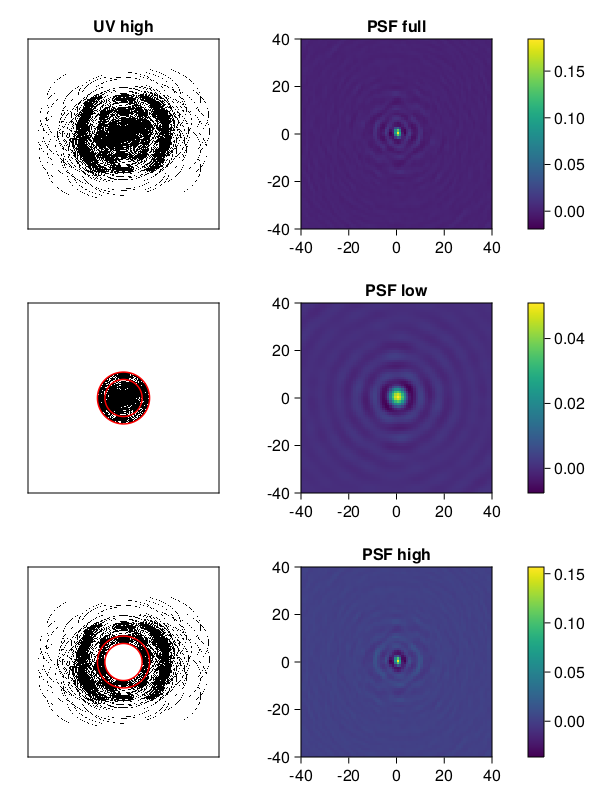

In [36]:
# sky file

sky = Float64.(read(FITS("Meerkat_Galactic_center_512.fits")[1]))
sky /= maximum(sky)
n_pix,  = size(sky)

# make all bases

bases = make_bases("uvgen-test.txt", n_pix)

# split bases and make psf's

ℓ = 60.0 # baseline center frequency (in pixels)
δ = 20.0  # baseline half width (in pixels)

psf, uv = make_psf(bases, n_pix, ℓ, δ) 
println("# short bases: $(sum(uv.low))")
println("# long bases: $(sum(uv.high))")

fig = plot_psf(psf, uv; zoom = 40)
#save("../../paper/figs/uv_psf.png", fig, px_per_unit = 4)

## Make dirty images

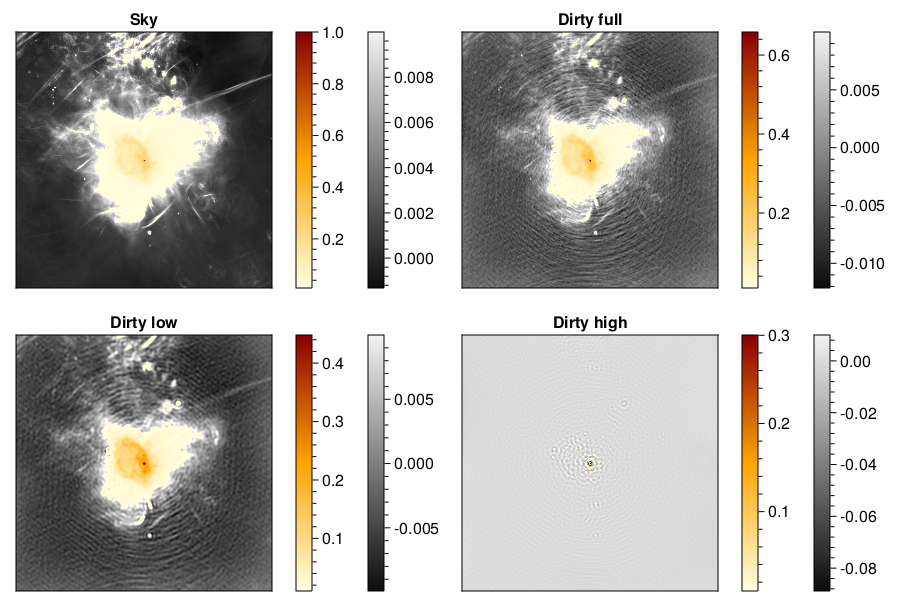

In [37]:
dirty = make_dirty(psf, sky, 0.0)
fig = plot_dirty_(dirty, sky)
#save("../../paper/figs/dirty.png", fig, px_per_unit = 4)

## Deconv with all visibilities

In [77]:
η = compute_step(psf.full)
i_full, mse = fista(psf.full, dirty.full, 1e-4, 100, η; sky=sky);

Computing... 100%|███████████████████████████████████████| Time: 0:00:36


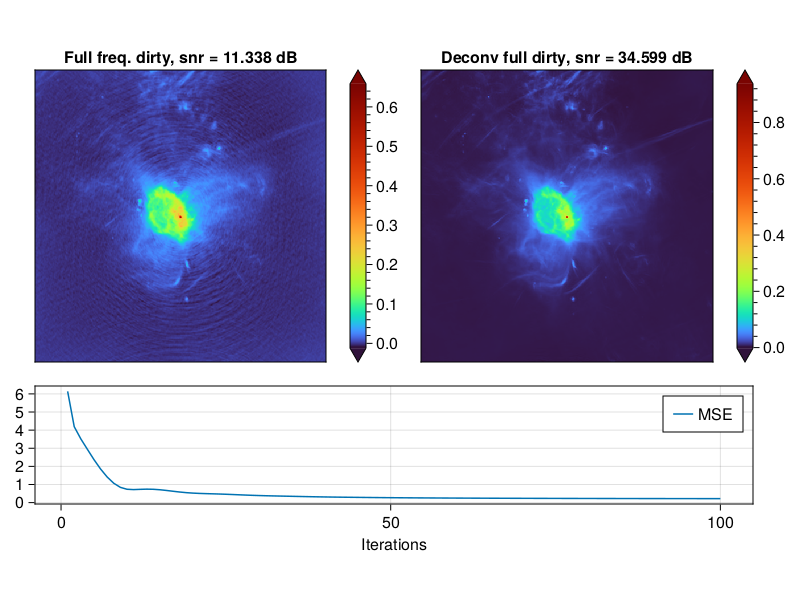

In [78]:
titles = ["Full freq. dirty, snr = $(snr(sky, dirty.full)) dB"
        "Deconv full dirty, snr = $(snr(sky, i_full)) dB"]
fig = plot_deconv(dirty.full, sky, i_full, mse, titles)
#save("../../paper/figs/recon_full.png", fig, px_per_unit = 4)

## Deconv with low frequencies

In [79]:
η = compute_step(psf.low)
i_low, mse = fista(psf.low, dirty.low, 1e-4, 100, η; sky=sky);

Computing... 100%|███████████████████████████████████████| Time: 0:00:36


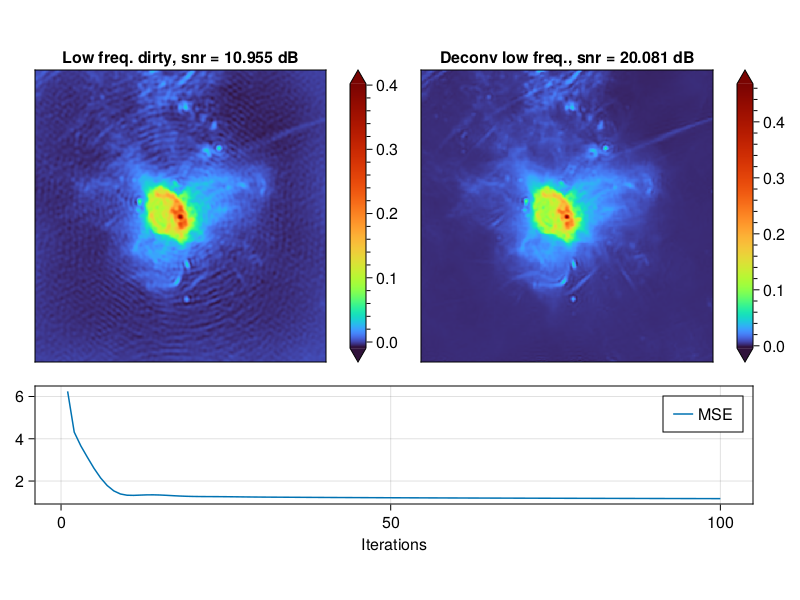

In [80]:
titles = ["Low freq. dirty, snr = $(snr(sky, dirty.low)) dB"
        "Deconv low freq., snr = $(snr(sky, i_low)) dB"]
fig = plot_deconv(dirty.low, sky, i_low, mse, titles)
#save("../../paper/figs/recon_low.png", fig, px_per_unit = 4)

## Add high frequencies

In [81]:
G = sqrt(sum(uv.high)/sum(uv.low))*low_pass(ℓ, n_pix)

η = compute_step(psf.high; G=G)
i_multistep, mse = fista(psf.high, dirty.high, 1e-4, 100, η; G=G, i₀ = i_low, sky=sky);

Computing... 100%|███████████████████████████████████████| Time: 0:00:50


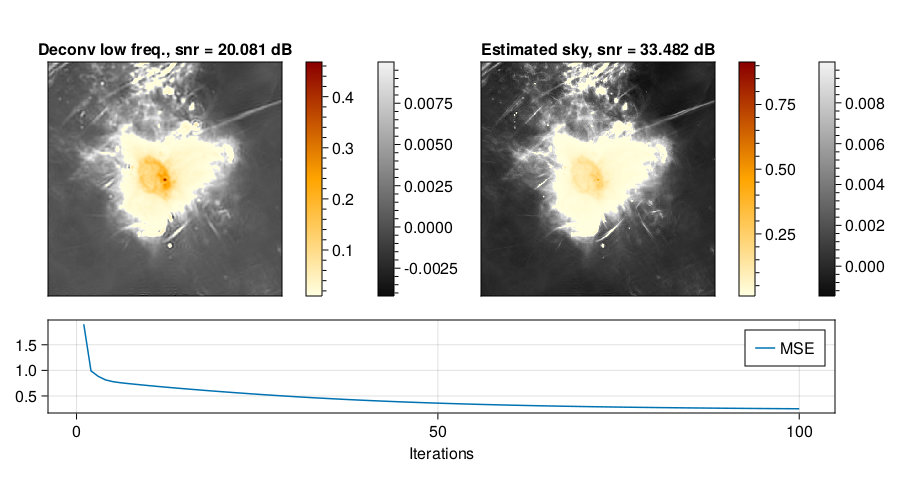

In [83]:
titles = ["Deconv low freq., snr = $(snr(sky, i_low)) dB", 
        "Estimated sky, snr = $(snr(sky, i_multistep)) dB"]
fig = plot_deconv_(i_low, sky, i_multistep, mse, titles)

#save("../../paper/figs/recon_2steps.png", fig, px_per_unit = 4)

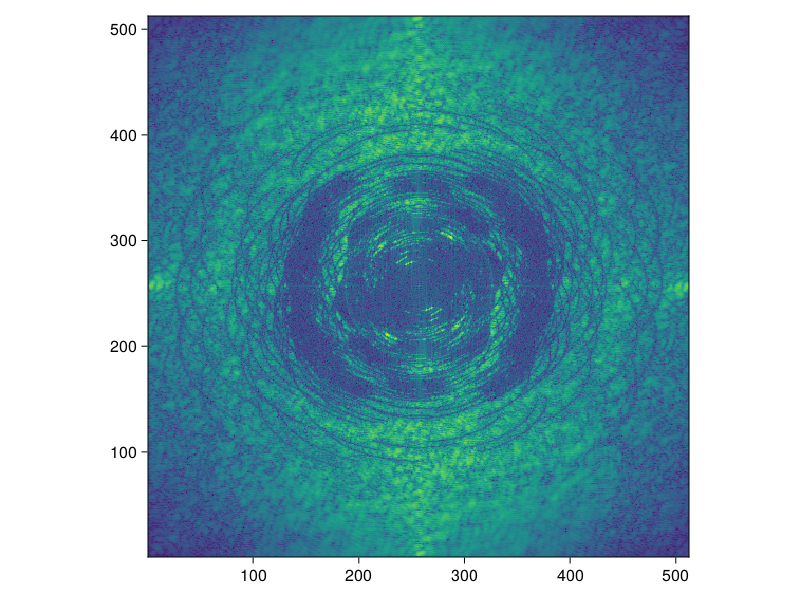

In [16]:
heatmap(DeconvMultiStep.fftshift(abs2.(DeconvMultiStep.fft(i_multistep - sky))).^0.1, axis=(;aspect=DataAspect()))

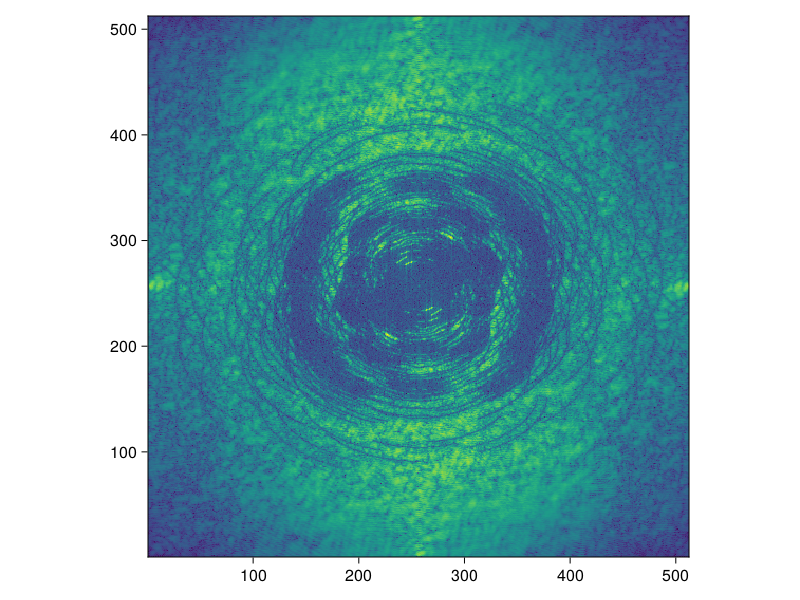

In [21]:
heatmap(DeconvMultiStep.fftshift(abs2.(DeconvMultiStep.fft(i_full - sky))).^0.1, axis=(;aspect=DataAspect()))

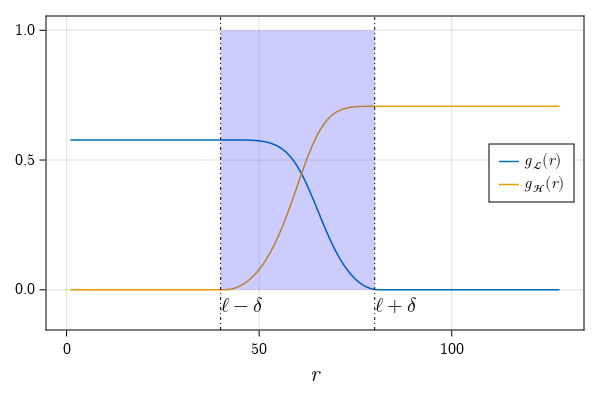

In [65]:
# plot filter

n_pix = 128
ℓ = 60.0
δ = 20.0

σ²=2.0
η²=3.0

g = filt_rad.(0:n_pix-1, ℓ, δ;σ²=σ², η²=η²)
gl = [tup[1] for tup in g]
gh = [tup[2] for tup in g]

fig = Figure(resolution = (600, 400), font = "CMU Serif")
ax = Axis(fig[1, 1],  xlabel = (L"r"), xlabelsize = 22)
lines!(ax, gl, label = L"g_\mathcal{L}(r)")
lines!(ax, gh, label = L"g_\mathcal{H}(r)")
#lines!(ax, σ²*gh.^2+η²*gl.^2, label = L"\sigma^2 g_\mathcal{L}(r)^2 + \eta^2 g_\mathcal{H}(r)^2")

vlines!(ax, [ℓ+δ]; color = :black, linewidth = 1, linestyle = :dashdot)
vlines!(ax, [ℓ-δ]; color = :black, linewidth = 1, linestyle = :dashdot, xticks = ([ℓ+δ], ["p"]))
text!(ax, L"\ell + \delta", position = (ℓ+δ, -0.1))
text!(ax, L"\ell - \delta", position = (ℓ-δ , -0.1))

band!([ℓ-δ, ℓ+δ], [0, 0], [1, 1]; color = (:blue, 0.2))

axislegend(position = :rc)
fig

# save("../../paper/figs/filts.png", fig, px_per_unit = 4)


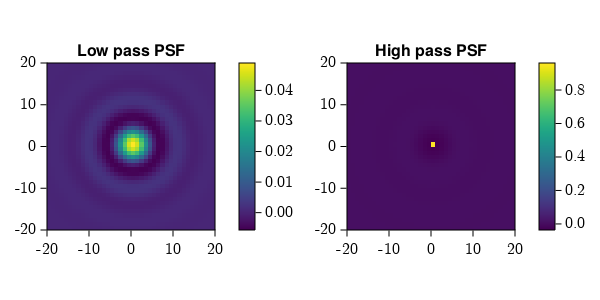

In [69]:
n_pix = 512
ℓ = 60.0
δ = 20.0

filter = make_filters(ℓ, δ, n_pix)

#function plot_filters(filter::Filters; zoom = 1.0)

nx, ny  =size(filter.LowPass)
lx, ly = LinRange(-nx/2, nx/2, nx), LinRange(-ny/2, ny/2, ny)

    fig = Figure(resolution = (600, 300), font = "CMU Serif")
    ax1 = Axis(fig[1, 1], aspect=DataAspect(); title="Low pass PSF") 
    ax2 = Axis(fig[1, 3], aspect=DataAspect(); title="High pass PSF") 

    hm1 = heatmap!(ax1, lx, ly, filter.LowPass)
    hm2 = heatmap!(ax2, lx, ly, filter.HighPass)

    zoom = 20
    xlims!(ax1, -zoom, zoom)
    ylims!(ax1, -zoom, zoom)
    xlims!(ax2, -zoom, zoom)
    ylims!(ax2, -zoom, zoom)

    Colorbar(fig[1, 2], hm1)
    Colorbar(fig[1, 4], hm2)

    rowsize!(fig.layout, 1, Aspect(1, 1))

    fig
#end

In [47]:
floor(Int, 5/2)+1

3

In [49]:
using FFTW

fftshift([1 2 3;4 5 6; 7 8 9])

3×3 Matrix{Int64}:
 9  7  8
 3  1  2
 6  4  5

In [50]:
[1 2 3;4 5 6; 7 8 9]

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [61]:
n = 4
iseven(n) ? Int(n/2 +1) : Int((n+1)/2)

3